<a href="https://colab.research.google.com/github/mmmovania/CUDA_Spring2023/blob/main/Week5/SharedMemoryBitmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-cr8y0bh_
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-cr8y0bh_
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=55dde118409bd2c76c9b65bad6746a372ec111350068e000a53ea925b1e57305
  Stored in directory: /tmp/pip-ephem-wheel-cache-hniz3su3/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [2]:
%%cu
#include <stdio.h>
#include <cuda.h>

const int WIDTH = 512;
const int HEIGHT = 512;
const int SIZE = WIDTH*HEIGHT;
const int IMAGE_SIZE_IN_BYTES = SIZE * sizeof(unsigned char)*4;

void load_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "rb");
	if (fp)
	{
		fread(pData, 1, SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot open raw image.");
	}
}

void save_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "wb");
	if (fp)
	{
		fwrite(pData, 4*sizeof(unsigned char), SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot write raw image.");
	}
}

__global__ void MakeImageKernel( unsigned char *ptr ) { 
	int x = threadIdx.x + blockIdx.x * blockDim.x;
	int y = threadIdx.y + blockIdx.y * blockDim.y;
	int offset = x + y * blockDim.x * gridDim.x;
	__shared__ float shared[16][16];
	const float period = 128.0f;
	const float PI = 3.14159f;
	shared[threadIdx.x][threadIdx.y] = 255 * (sinf(x*2.0f*PI/ period) + 1.0f) * (sinf(y*2.0f*PI/ period) + 1.0f) / 4.0f;
	//__syncthreads(); //uncomment this line to get correct output
	ptr[offset*4+0]=0;
	ptr[offset*4+1]=shared[15-threadIdx.x][15-threadIdx.y];
	ptr[offset*4+2]=0;
	ptr[offset*4+3]=255;
}



int main(int argc, char** argv)
{ 
	unsigned char* host_bitmap = (unsigned char*)malloc(IMAGE_SIZE_IN_BYTES);
	unsigned char* dev_bitmap; 
	
	cudaMalloc(&dev_bitmap, IMAGE_SIZE_IN_BYTES); 
  
	dim3    blocksGrid;
	dim3    threadsBlock(16, 16, 1);
	blocksGrid.x = ceil(WIDTH / 16.0);
	blocksGrid.y = ceil(HEIGHT / 16.0);

	MakeImageKernel << <blocksGrid, threadsBlock >> >(dev_bitmap);

	cudaMemcpy(host_bitmap, dev_bitmap, IMAGE_SIZE_IN_BYTES, cudaMemcpyDeviceToHost);

	save_raw_image("/content/OutputImage.raw", host_bitmap);

	free(host_bitmap);
	cudaFree(&dev_bitmap); 
  cudaDeviceReset();
	return 0;
}

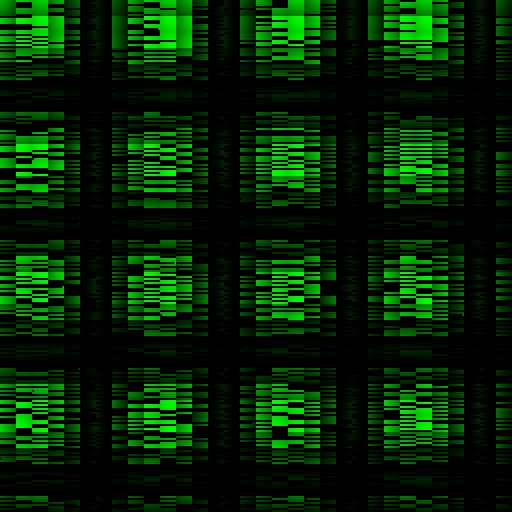

In [3]:
import numpy as np

#lets view our image 
fd = open('/content/OutputImage.raw', 'rb')
rows = 512
cols = 512
f = np.fromfile(fd, dtype=np.uint8,count=rows*cols*4)
im = f.reshape((rows, cols, 4)) #notice row, column format
fd.close()

from google.colab.patches import cv2_imshow
#display image using cv2_imshow
cv2_imshow(im)